nb of poi = 17, nb of empl. = 141. Ratio = 12.06 %
[array([               0,               58,                0,                0,                0,                0,
                  47304,                3,                0,            47304,                0,                0,
                     16,                0,                1,                0,                0,                0,
                      0,                0,                0]),
 array([               0,              952,                0,                0,           850477,                0,
                      0,              739,                0,           850477,                0,                0,
                     26,                0,                0,                0,                0,                0,
                     10,                0,                0]),
 array([          224305,                0,                0,          2652612,                0,           800000,
               

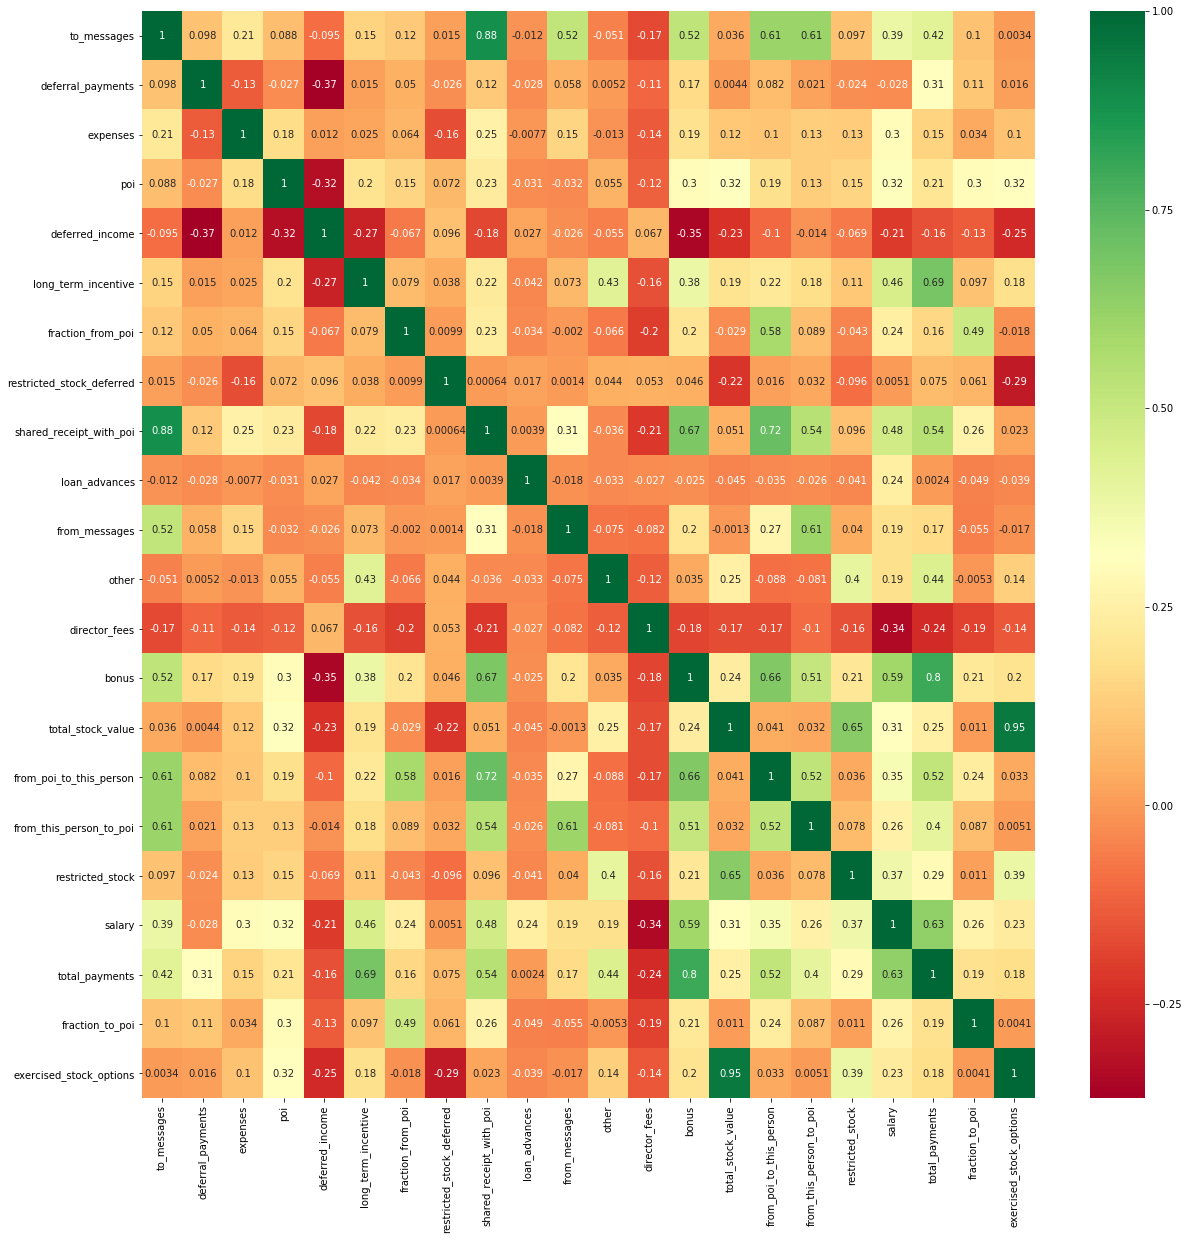

In [15]:
#PCA inutile, ne pas intégrer dans la pipeline
#Scaling utile, reflexion à avoir sur le type de scaling à appliquer
#Same avec les Clf 


import sys
import math
import operator
import pickle
from pprint import pprint as pp
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline



#from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif










#sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data









def isnan(value):
    try:
        return math.isnan(float(value))
    except:
        return False


def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
    """
    
    fraction = 0.
    
    poi_messages = float(poi_messages)
    all_messages = float(all_messages)
    
    if isnan(poi_messages) or poi_messages == 0:
        fraction = 0.
    else: fraction = poi_messages / all_messages
    
    return round(fraction, 3)












### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)












### Task 1: Select what features you'll use
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".



features_list = [
    'poi',
    'salary',
    'to_messages',
    'deferral_payments',
    'total_payments',
    'exercised_stock_options',
    'bonus',
    'restricted_stock',
    'shared_receipt_with_poi',
    'restricted_stock_deferred',
    'total_stock_value',
    'expenses',
    'loan_advances',
    'from_messages',
    'other',
    'from_this_person_to_poi',
    'director_fees',
    'deferred_income',
    'long_term_incentive',
    #'email_address',
    'from_poi_to_this_person',
]



### KPI


"""
print "Total people:", len(data_dict)
print
"""
poi = set()
for empl in data_dict:
    if data_dict[empl]['poi'] == True:poi.add(empl)
"""
print "Total POI = {} / non-POI = {}".format(len(poi), (len(data_dict) - len(poi)))
print "Ratio POI = {} % / non-POI = {} %".format(\
    round((float(len(poi))/len(data_dict))*100, 2) , round((float((len(data_dict) - len(poi)))/len(data_dict))*100, 2))
print

print "Total label + features:", len(data_dict['LAY KENNETH L'])
feature_nan_dict = dict()
for _, values in data_dict.items():
    for key, value in values.items():
        if isnan(value):
            if key not in feature_nan_dict:
                feature_nan_dict[key] = 1
            else: feature_nan_dict[key] += 1
print "Quantity of NaN per feature:"
pp(feature_nan_dict)
"""


















### Task 2: Remove outliers & errors



#Before
#print "nb of poi = {}, nb of empl. = {}. Ratio = {} %".format(len(poi), len(data_dict),\
#                                                            round( float( len(poi)) / len(data_dict), 4)*100 )



#Removing persona with low amount of data
ratio_high_NaN = 0.85
high_NaN = dict()
for name, values in data_dict.items():
    i = 0
    for _, value in values.items():
        if isnan(value): i += 1
    if (i / 21.) >= ratio_high_NaN: high_NaN[name] = i / 21.
#pp(sorted(high_NaN.items(), key=operator.itemgetter(1), reverse=True))

#Removing outliers
outliers = ('LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK')
for k in outliers:
    data_dict.pop(k, None)



#Replacing NaN values by 0
for _, values in data_dict.items():
    for key, value in values.items():
        if isnan(value):
            values[key] = 0
pd_data = pd.DataFrame.from_dict(data_dict, orient='index')



#Removing Statistical outlier (https://en.wikipedia.org/wiki/Interquartile_range)

# Computing IQR using Pandas functionnality
Q1 = pd_data.quantile(0.25)
Q3 = pd_data.quantile(0.75)
IQR = Q3 - Q1
series_outl = [pd_data[(pd_data>(Q3 + 1.5*IQR) ) | (pd_data<(Q1 - 1.5*IQR) )].count(axis=1), pd_data['poi']]
series_outl[0].name = "bad_feats"
outl = pd.concat(series_outl, axis=1)
outl.sort_values(by='bad_feats', ascending=False, inplace=True)
#print outl.head(8)

#Removing outliers
outliers = ('LAY KENNETH L', 'TOTAL', 'FREVERT MARK A')
for k in outliers:
    data_dict.pop(k, None)

#After
poi2 = set()
for empl in data_dict:
    if data_dict[empl]['poi'] == True:poi2.add(empl)
print "nb of poi = {}, nb of empl. = {}. Ratio = {} %".format(len(poi2), len(data_dict),\
                                                            round( float( len(poi2)) / len(data_dict), 4)*100 )



#Removing errors

#Check sums
payment_sum = [
    'salary',
    'deferral_payments',
    'bonus',
    'expenses',
    'loan_advances',
    'other',
    'director_fees',
    'deferred_income',
    'long_term_incentive',
]

stock_sum = [
    'exercised_stock_options',
    'restricted_stock',
    'restricted_stock_deferred',
]

delta_pay = pd_data[payment_sum].sum(axis=1) != pd_data['total_payments']
delta_stock = pd_data[stock_sum].sum(axis=1) != pd_data['total_stock_value']

#print list(delta_pay[delta_pay==True].index), list(delta_stock[delta_stock==True].index)


#Corrections
data_dict['BELFER ROBERT']['deferral_payments'] = 0
data_dict['BELFER ROBERT']['total_payments'] = 3285
data_dict['BELFER ROBERT']['exercised_stock_options'] = 0
data_dict['BELFER ROBERT']['restricted_stock'] = 44093
data_dict['BELFER ROBERT']['restricted_stock_deferred'] = -44093
data_dict['BELFER ROBERT']['total_stock_value'] = 0
data_dict['BELFER ROBERT']['expenses'] = 3285
data_dict['BELFER ROBERT']['deferred_income'] = -102500
data_dict['BELFER ROBERT']['director_fees'] = 102500

data_dict['BHATNAGAR SANJAY']['total_payments'] = 137864
data_dict['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290
data_dict['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
data_dict['BHATNAGAR SANJAY']['total_stock_value'] = 15456290
data_dict['BHATNAGAR SANJAY']['expenses'] = 137864
data_dict['BHATNAGAR SANJAY']['other'] = 0
data_dict['BHATNAGAR SANJAY']['director_fees'] = 0


pd_data = pd.DataFrame.from_dict(data_dict, orient='index')

delta_pay = pd_data[payment_sum].sum(axis=1) != pd_data['total_payments']
delta_stock = pd_data[stock_sum].sum(axis=1) != pd_data['total_stock_value']

#print list(delta_pay[delta_pay==True].index), list(delta_pay[delta_stock==True].index)










### Task 3: Create, & remove feature(s)


#New features (basic ratios)
for name in data_dict:

    data_point = data_dict[name]
    
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi

    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi

features_list.append('fraction_from_poi')
features_list.append('fraction_to_poi')



#Correlation Matrix with Heatmap (from https://towardsdatascience.com/)
#To identify added value of new features
pd_data = pd.DataFrame.from_dict(data_dict, orient='index')

corrmat = pd_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(pd_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")






### Store to my_dataset for easy export below.
my_dataset = data_dict



### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:16.0f}'.format}, linewidth=130)



###Replacing train_test_split by StratifiedShuffleSplit
###To have stratified & shuffled split 
sss = StratifiedShuffleSplit(1000, test_size= 0.25\
                             #, random_state = 42\ #Attention pour iterations
                            )
sss.get_n_splits(features, labels)

for train_index, test_index in sss.split(features, labels): 
    features_train = list()
    features_test  = list()
    labels_train   = list()
    labels_test    = list()
    for ii in train_index:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_index:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )




"""
#minMax Scaling
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)


#Univariate feature selector with configurable strategy
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html

k = 15
transformer = GenericUnivariateSelect(chi2, mode='k_best', param=k)
features_uni = transformer.fit_transform(features, labels)
feat_scores = zip(features_list[1:], transformer.scores_)
feat_scores_order = sorted(dict(feat_scores).items(), key=operator.itemgetter(1), reverse=True)

pp (feat_scores_order[:15])
"""

























### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

#dump_classifier_and_data(clf, my_dataset, features_list)
print "done"